# Modeling Tarmac Times at Airports
This notebooks will use the 2016 airline departure delays dataset to attempt to model the time spent stuck taxiing on the tarmac during flights in R. Before modeling, the notebook will go over a few simple visualization techniques using the `ggplot2` library in R.

## Download and Import

In [1]:
download.file(url="https://raw.githubusercontent.com/nwngeek212/DSX-DemoCenter/master/tarmacTimes/data_assets/2016.csv", destfile="2016.csv")

We will be using the `data.table` library in R. The `2016.csv` file is an abridged version of the full dataset available from the Bureau of Transportation Statistics. Our dataset contains 100000 random entries from 

In [2]:
library(data.table)
library(ggplot2)

all <- fread("2016.csv", stringsAsFactors = TRUE)
head(all)


Attaching package: ‘data.table’

The following objects are masked from ‘package:SparkR’:

    between, first, hour, last, like, minute, month, quarter, second,
    tables, year



Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,...,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,TotalTaxi
2016,4,11,13,7,2016-11-13,AA,19805,AA,N3HUAA,...,192,173,1,1372,6,1,0,0,0,19
2016,2,6,6,1,2016-06-06,DL,19790,DL,N624AG,...,371,334,1,2422,10,NA,NA,NA,NA,37
2016,4,12,7,3,2016-12-07,AS,19930,AS,N587AS,...,334,322,1,2797,11,NA,NA,NA,NA,12
2016,2,6,27,1,2016-06-27,OO,20304,OO,N440SW,...,56,42,1,223,1,NA,NA,NA,NA,14
2016,1,2,29,1,2016-02-29,AS,19930,AS,N513AS,...,424,409,1,2701,11,NA,NA,NA,NA,15
2016,2,4,12,2,2016-04-12,WN,19393,WN,N915WN,...,133,119,1,998,4,NA,NA,NA,NA,14


For some introductory data exploration, we could look at the frequencies of all the major carriers:

In [3]:
summary(all$UniqueCarrier)

AA    AS    B6    DL    EV    F9    HA    NK    OO    UA    VX    WN 
16262  3120  5152 16456  8688  1677  1395  2437 10797  9576  1219 23221

Let's create a `TotalTaxi` variable which will contain the sum of the `TaxiOut` and `TaxiIn` times. This will give a better idea of how much time was wasted just sitting on the tarmac for each flight.

In [4]:
all$TotalTaxi <- all$TaxiIn + all$TaxiOut

## Data Visualization
We can plot a histogram using the `TotalTaxi` variable we just created to see what the averages and extremes are for tarmac times.

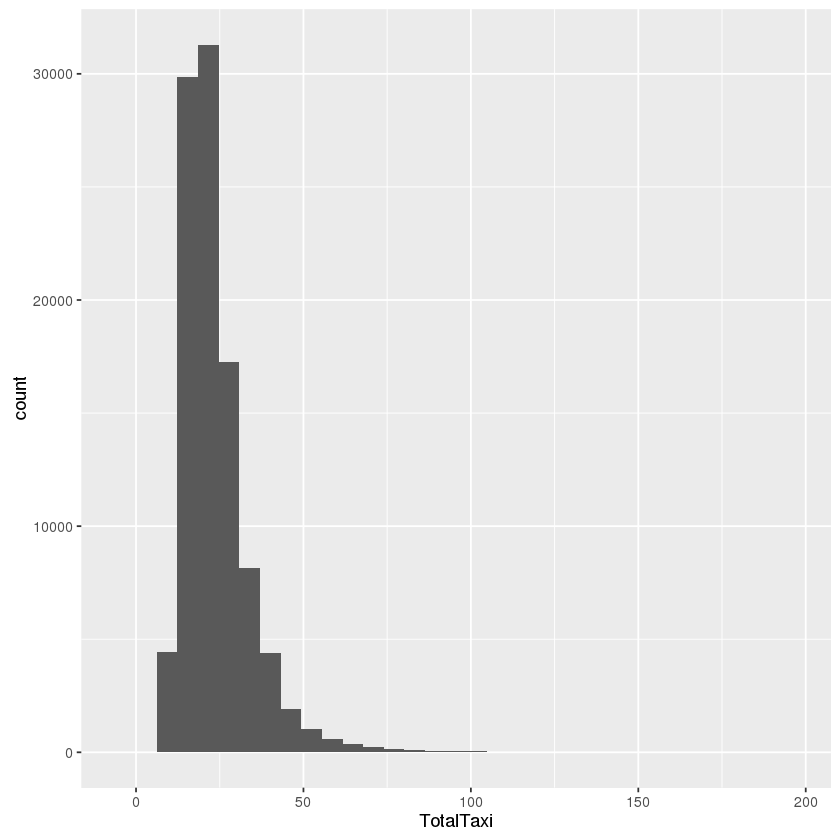

In [5]:
ggplot(data=all, aes(x=TotalTaxi)) + geom_histogram(bins=30)

Initial observation suggests that nearly all the total taxi times lie between 10 and 100 minutes. But we also notice that the data appears to be skewed in a fashion suitable for a $log$ transformation. We'll use $log_{10}$ for easier interpretation.

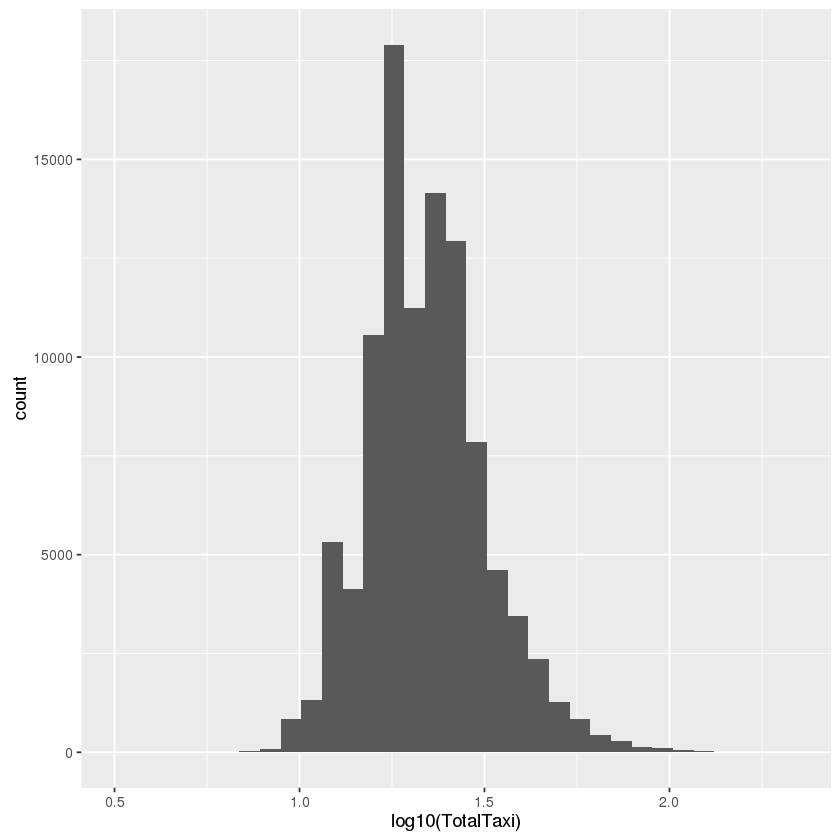

In [6]:
ggplot(data=all, aes(x=log10(TotalTaxi))) + geom_histogram(bins=30)

Recall that since we are using a $log_{10}$ transformation, 1.0 on this plot denotes a `TotalTaxi` time of 10 minutes ($10^1$), while 2.0 denotes $10^2=100$

In [7]:
medTaxi <- median(log10(all$TotalTaxi))
medTaxi

[1] 1.322219

The median log-transformed total taxi time is 1.32. We can raise 10 to the power of this number to discover the true median.

In [8]:
10^medTaxi

[1] 21

It may be interesting to see if different carriers have different distributions of their total taxi times. We can color code the histogram by our `UniqueCarrier` variable to discover this.

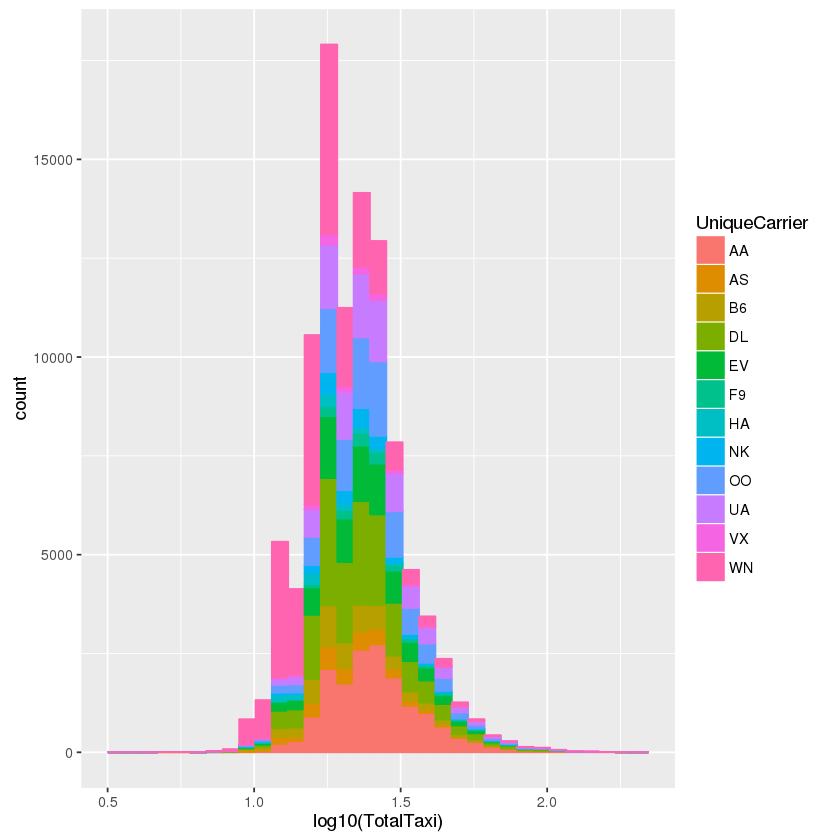

In [9]:
ggplot(data=all, aes(x=log10(TotalTaxi))) + geom_histogram(bins=30, aes(fill=UniqueCarrier, col=UniqueCarrier))

There doesn't seem to be a discernable difference across the various airlines.

## Origin & Destination Frequencies
For the second part of this demo, we'll calculate the frequencies of all the departure and arrival airports and also calculate the mean taxi times at each of those airports

In [10]:
origin_freq <- all[,.(freqOut=.N, meanTaxiOut = mean(TaxiOut)),by=Origin]
dest_freq <- all[,.(freqIn=.N, meanTaxiIn = mean(TaxiIn)),by=Dest]
head(origin_freq)

Origin,freqOut,meanTaxiOut
DFW,3442,18.021209
JFK,1807,25.695628
OGG,431,9.821346
MSP,2273,18.659481
SEA,2348,17.853066
MSY,759,11.511199


Let's merge the origin and destination frequency tables and sum their `meantTaxi` variables.

In [11]:
freq_by_taxi <- merge(origin_freq,dest_freq, by.x="Origin",by.y="Dest")
freq_by_taxi$airport <- freq_by_taxi$Origin
freq_by_taxi$meanTaxi <- freq_by_taxi$meanTaxiOut + freq_by_taxi$meanTaxiIn
freq_by_taxi$freq <- freq_by_taxi$freqIn + freq_by_taxi$freqOut
freq_by_taxi <- freq_by_taxi[,.(airport,freq,meanTaxi)]
head(freq_by_taxi)

airport,freq,meanTaxi
ABE,94,19.68148
ABI,3,31.00000
ABQ,661,16.81647
ABR,31,24.71667
ABY,28,13.05000
ACK,19,24.41111


Recall that in order to limit filesize, our `all` variable only contains a subset of 100000 flights out of the entire `2016.csv` dataset. The frequencies generated will of course only be calculated out of these 100000 flights. I've already run this notebook using the entire 2016 frequency data, and we'll import it below to improve the performance of our future model.

In [12]:
download.file(url="https://raw.githubusercontent.com/nwngeek212/DSX-DemoCenter/master/tarmacTimes/data_assets/2016_airport_freq.csv",destfile="2016_airport_freq.csv")
freq_by_taxi <- fread("2016_airport_freq.csv")

In [13]:
head(freq_by_taxi)

airport,freq,meanTaxi
SPN,2,10
MHK,2,8
IAG,765,208
OKC,30996,335
JFK,192393,386
IAH,269751,396


Let's plot a frequency vs. meanTaxi plot. The idea is to see whether the number of flights in and out of an airport at all correlates with the mean amount of time you'll be stuck on the tarmac at that airport.

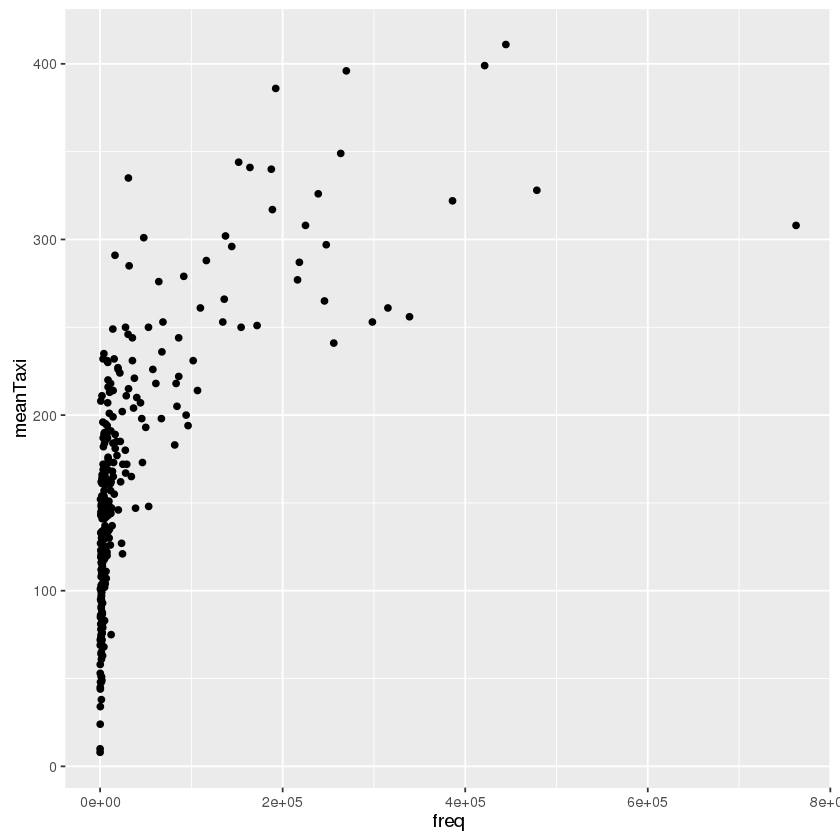

In [14]:
ggplot(data=freq_by_taxi, aes(x=freq)) + geom_point(aes(y=meanTaxi))

Again, it seems like this data is well suited for a log transformation.

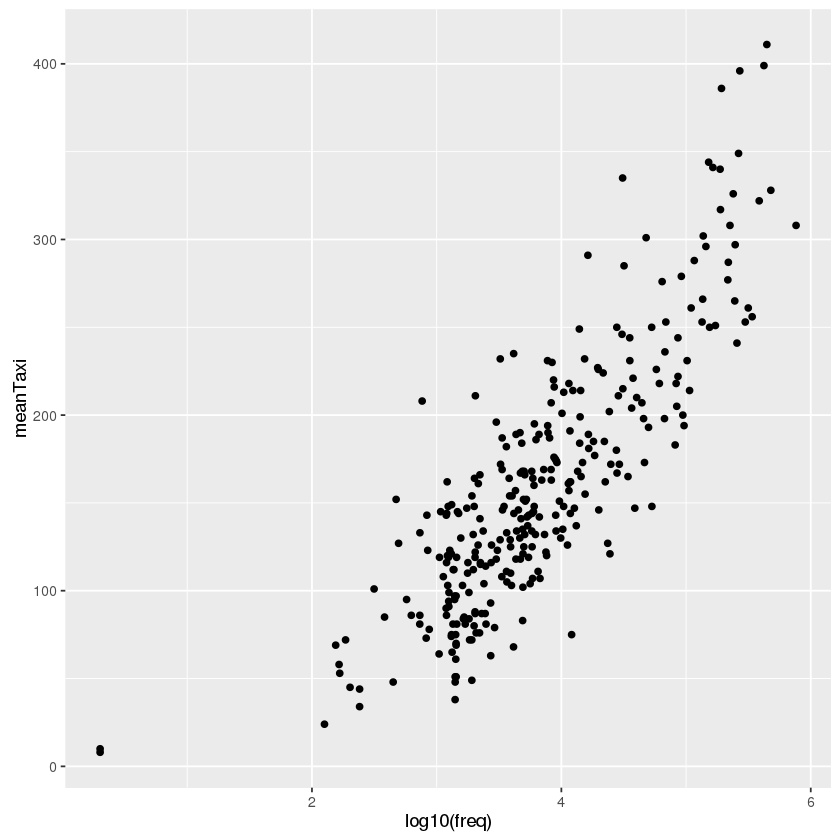

In [15]:
ggplot(data=freq_by_taxi, aes(x=log10(freq),y=meanTaxi)) + geom_point(aes(y=meanTaxi))

There are two outliers here:

In [16]:
head(freq_by_taxi,2)

airport,freq,meanTaxi
SPN,2,10
MHK,2,8


There were only 2 flights in and out of these airports in the entire year. We should probably remove these points because they will significantly bias our model.

## Linear Regression
Let's create a linear regression mapping the frequency of flights at a given airport to the mean total taxi time at that airport. First, let us remove the 2 outlier points

In [17]:
freq_by_taxi <- freq_by_taxi[freq > 2]

We'll create our linear model below:

In [18]:
linear_model <- lm(meanTaxi~log10(freq),data=freq_by_taxi)
summary(linear_model)


Call:
lm(formula = meanTaxi ~ log10(freq), data = freq_by_taxi)

Residuals:
    Min      1Q  Median      3Q     Max 
-105.16  -28.15   -4.07   24.89  123.73 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -146.412     11.364  -12.88   <2e-16 ***
log10(freq)   79.996      2.899   27.60   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 38.79 on 306 degrees of freedom
Multiple R-squared:  0.7134,	Adjusted R-squared:  0.7124 
F-statistic: 761.6 on 1 and 306 DF,  p-value: < 2.2e-16


Let's plot our least squares regression line with the data, including the standard errors:

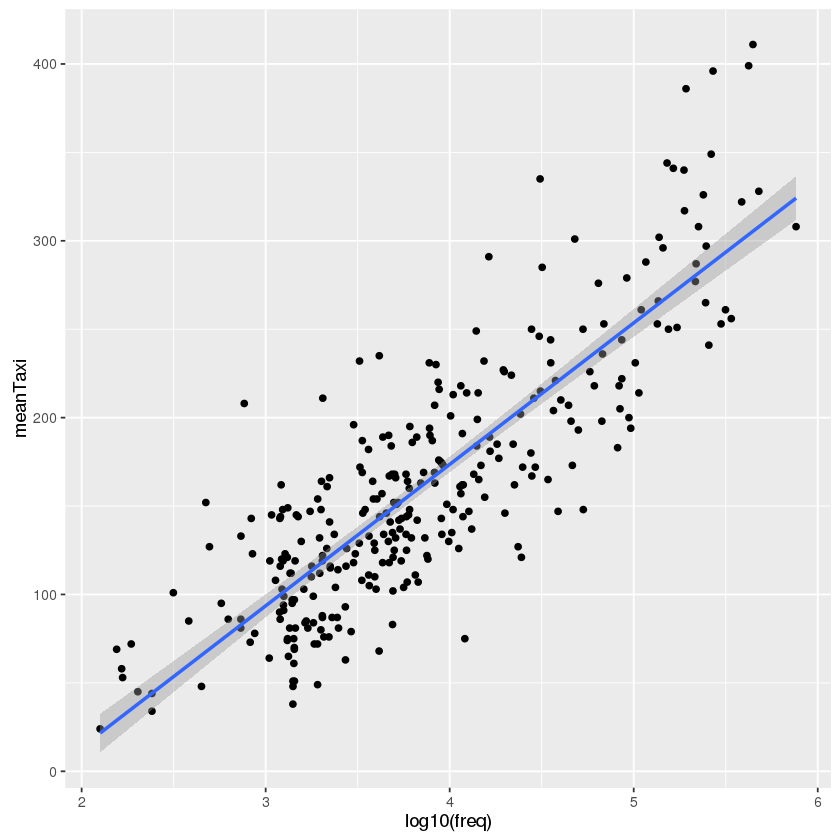

In [19]:
ggplot(data=freq_by_taxi, aes(x=log10(freq),y=meanTaxi)) + geom_point(aes(y=meanTaxi)) + geom_smooth(method = "lm")

## Conclusions
We see a relatively high $R^2$ value and relatively low model bias. We also notice however, that the model is not very precise with regards to the data. We can expect a relatively high error rate.

In [20]:
freq_by_taxi$y_pred <- predict(linear_model,freq_by_taxi)
freq_by_taxi$error <- abs(freq_by_taxi$y_pred - freq_by_taxi$meanTaxi)
mean_error <- mean(freq_by_taxi$error)
mean_error

[1] 30.51957

As predicted, the mean error is fairly high at around 30 minutes. The good news is that we can use the model to provide an indication of a general trend between flight frequency and mean taxi times.

A question to close out this notebook though: why? Shouldn't airports with a higher density of flights have more runways, and thus be able to accomodate more flight departures and landings? Clearly this isn't the case.